In [1]:
import os
from typing import Callable, Optional

import hydra
import torch
from matplotlib.pylab import f
from omegaconf import DictConfig, OmegaConf
from sklearn.metrics import accuracy_score
from torch import nn
from torch.nn.utils import clip_grad_norm_, clip_grad_value_
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

import wandb
from data import get_dataloaders
from model import AttnNet, ResNet
from utils import AttrDict
import yaml
from hydra import compose, initialize
from torchaudio.transforms import Spectrogram
from hydra.core.hydra_config import HydraConfig
import matplotlib.pyplot as plt
from torchaudio.transforms import AmplitudeToDB
from utils import count_parameters

In [7]:
with initialize(version_base=None, config_path="config", job_name="test"):
    config = compose(config_name="config", overrides=["wandb.mode=disabled", "+model=resnet", "+data=spec"])
    config = OmegaConf.to_container(config, resolve=True)
    config = AttrDict(config)

In [8]:
# Set the matmul precision
torch.set_float32_matmul_precision(config.train.matmul_precision)
# Get device and initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if config.model.name == "attn":
    config.model.kwargs.seq_length = int(
            config.data.conjunction.model_epoch_len
            * config.data.conjunction.model_sf
            * config.data.conjunction.context_window
        )
    model = AttnNet(**config.model.kwargs).to(device)
    state_dict = torch.load("checkpoints/eager-violet-6/checkpoint.pt")
    model.load_state_dict(state_dict["model_state_dict"])
elif config.model.name == "resnet":
    model = ResNet(**config.model.kwargs).to(device)

# Get the data loaders
train_loader, test_loader, val_loader = get_dataloaders(config.data)

In [4]:
train_loader.dataset.data_transform

Sequential(
  (0): Spectrogram()
  (1): AmplitudeToDB()
)

In [5]:
count_parameters(model)

2797123

In [6]:
correct = 0
total = 0
label_counts = torch.zeros(3)
all_predictions = []
all_labels = []

for i, (x, labels) in enumerate(tqdm(val_loader)):
    x = x.to(device)
    labels = labels.to(device)
    outputs = model(x)
    all_predictions.append(outputs.argmax(-1).detach())
    all_labels.append(labels)

  0%|          | 0/540 [00:00<?, ?it/s]

 22%|██▏       | 120/540 [00:04<00:14, 28.39it/s]


KeyboardInterrupt: 

In [ ]:
weight = val_loader.dataset.weight.to(device)
predictions = torch.cat(all_predictions)
labels = torch.cat(all_labels)
accuracy = (predictions == labels).sum().item() / labels.shape[0]
weighted_accuracy = ((predictions == labels) * weight[labels]).sum().item() / weight[labels].sum().item()
prediction_unique, prediction_count = torch.unique(predictions.cpu(), return_counts=True)
label_unique, label_count = torch.unique(labels.cpu(), return_counts=True)

In [126]:
print(f"Accuracy: {accuracy}")
print(f"Weighted Accuracy: {weighted_accuracy}")
print(f"Prediction Count: {prediction_count}")
print(f"Label Count: {label_count}")


Accuracy: 0.5729498234851554
Weighted Accuracy: 0.3115834678264384
Prediction Count: tensor([30384,  4174])
Label Count: tensor([22773, 10816,   969])


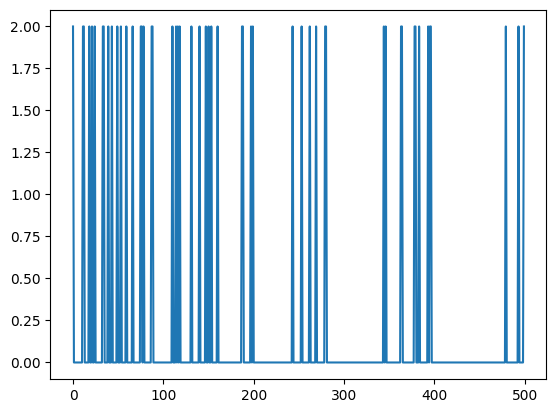

In [127]:
plt.plot(predictions[:500].cpu())

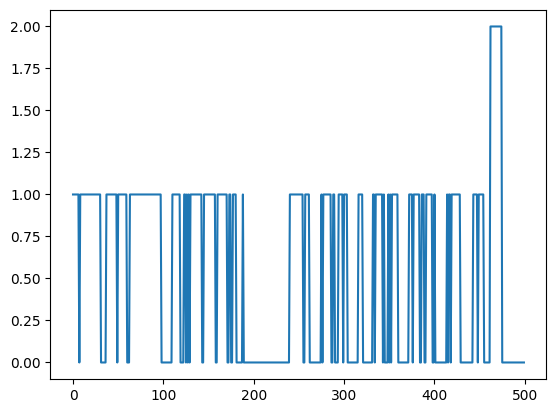

In [128]:
plt.plot(labels[:500].cpu())